In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [3]:
filter_size1=5
num_filters1=16
filter_size2=5
num_filters2=36
fc_size=128

In [4]:
from mnist import MNIST
data=MNIST(data_dir="data/MNIST/")

In [5]:

print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [6]:
img_size = data.img_size
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes
num_channels = data.num_channels

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

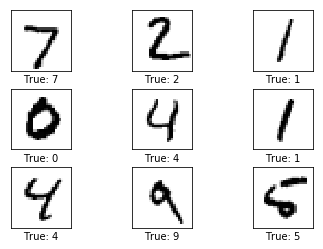

In [8]:
images = data.x_test[0:9]
cls_true = data.y_test_cls[0:9]
plot_images(images=images, cls_true=cls_true)

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [10]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [11]:
def new_conv_layer(input,num_input_channels,filter_size,num_filters,use_pooling=True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,filter=weights,strides=[1, 1, 1, 1],padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

In [12]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [13]:
def new_fc_layer(input,num_inputs,num_outputs,use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [15]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [16]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [17]:
y_true_cls = tf.argmax(y_true, axis=1)

In [18]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,num_input_channels=num_channels,filter_size=filter_size1,num_filters=num_filters1,use_pooling=True)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [20]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,num_input_channels=num_filters1,filter_size=filter_size2,num_filters=num_filters2,use_pooling=True)

In [21]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [22]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [23]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [24]:
num_features

1764

In [25]:
layer_fc1 = new_fc_layer(input=layer_flat,num_inputs=num_features,num_outputs=fc_size,use_relu=True)

In [26]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [27]:
layer_fc2 = new_fc_layer(input=layer_fc1,num_inputs=fc_size,num_outputs=num_classes,use_relu=False)

In [28]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [29]:
y_pred = tf.nn.softmax(layer_fc2)

In [30]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [32]:
cost = tf.reduce_mean(cross_entropy)

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [34]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [35]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
session = tf.Session()

In [37]:
session.run(tf.global_variables_initializer())

In [38]:
train_batch_size = 64

In [39]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [40]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    plot_images(images=images[0:9],cls_true=cls_true[0:9],cls_pred=cls_pred[0:9])

In [41]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.y_test_cls
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [42]:
test_batch_size = 256
def print_test_accuracy(show_example_errors=False,show_confusion_matrix=False):
    num_test = data.num_test
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.x_test[i:j, :]
        labels = data.y_test[i:j, :]
        feed_dict = {x: images,y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.y_test_cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [43]:
print_test_accuracy()

Accuracy on Test-Set: 10.5% (1055 / 10000)


In [44]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  12.5%
Time usage: 0:00:00


In [45]:
print_test_accuracy()

Accuracy on Test-Set: 10.3% (1032 / 10000)


In [46]:
optimize(num_iterations=99)

Time usage: 0:00:07


Accuracy on Test-Set: 57.5% (5745 / 10000)
Example errors:


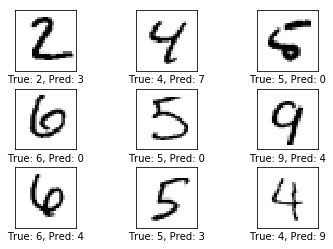

In [47]:
print_test_accuracy(show_example_errors=True)

In [48]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  53.1%
Optimization Iteration:    201, Training Accuracy:  81.2%
Optimization Iteration:    301, Training Accuracy:  85.9%
Optimization Iteration:    401, Training Accuracy:  93.8%
Optimization Iteration:    501, Training Accuracy:  90.6%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  96.9%
Optimization Iteration:    901, Training Accuracy:  89.1%
Time usage: 0:01:09


Accuracy on Test-Set: 93.0% (9303 / 10000)
Example errors:


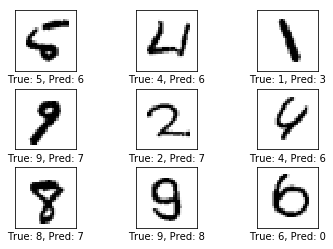

In [49]:
print_test_accuracy(show_example_errors=True)

In [50]:
optimize(num_iterations=9000)

Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  92.2%
Optimization Iteration:   1301, Training Accuracy:  92.2%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization Iteration:   1801, Training Accuracy: 100.0%
Optimization Iteration:   1901, Training Accuracy:  87.5%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy:  96.9%
Optimization I

Accuracy on Test-Set: 98.7% (9869 / 10000)
Example errors:


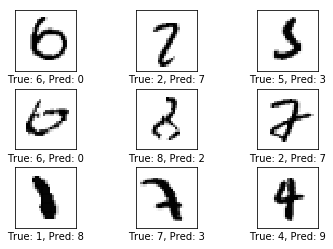

Confusion Matrix:
[[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1127    3    0    1    0    1    2    1    0]
 [   2    1 1019    1    1    0    0    7    1    0]
 [   1    0    0 1003    0    2    0    1    2    1]
 [   0    0    0    0  970    0    0    1    1   10]
 [   2    0    0    7    0  877    2    1    1    2]
 [  10    3    0    1    2    4  936    0    2    0]
 [   0    1    5    3    0    0    0 1016    1    2]
 [   4    0    3    3    1    1    0    3  954    5]
 [   3    4    0    2    2    2    0    4    1  991]]


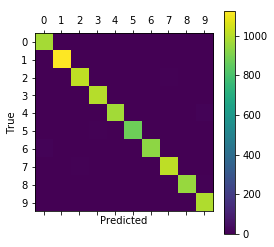

In [51]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [52]:
session.close()